Table of Contents. 
1. Import libraries and data.  
2. Correlation heatmap.  
3. Scatterplot.  
4. Hypothesis.  
5. Data preparation: reshaping variables for regression.
6. Regression analysis.

1. Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Ensure that plots show in the notebook

%matplotlib inline

In [3]:
# Load dataset
df = pd.read_excel("Tesla_Global_Deliveries_Cleaned.xlsx")

In [4]:
# Quick data check
display(df.head())
display(df.info())
display(df.describe().T)

,Year,Month,Region,Model,Estimated_Deliveries,Production_Units,Avg_Price_USD,Battery_Capacity_kWh,Range_km,CO2_Saved_tons,Source_Type,Charging_Stations
0,2015,4,Europe,Model X,8458,9039,88193.18,120,716,908.39,Interpolated (Month),7633
1,2015,3,Europe,Model X,3940,4493,98722.09,75,433,255.90,Interpolated (Month),4166
2,2015,6,Europe,Model 3,8922,9609,104855.71,75,427,571.45,Official (Quarter),10465
3,2015,2,Asia,Model S,12347,12514,108471.17,82,464,859.35,Interpolated (Month),5238
4,2015,12,Middle East,Model Y,7294,7513,84411.62,82,453,495.63,Interpolated (Month),9983


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  2640 non-null   int64  
 1   Month                 2640 non-null   int64  
 2   Region                2640 non-null   object 
 3   Model                 2640 non-null   object 
 4   Estimated_Deliveries  2640 non-null   int64  
 5   Production_Units      2640 non-null   int64  
 6   Avg_Price_USD         2640 non-null   float64
 7   Battery_Capacity_kWh  2640 non-null   int64  
 8   Range_km              2640 non-null   int64  
 9   CO2_Saved_tons        2640 non-null   float64
 10  Source_Type           2640 non-null   object 
 11  Charging_Stations     2640 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 247.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
Year,2640.0,2020.000000,3.162877,2015.00,2017.000,2020.000,2023.0000,2025.00
Month,2640.0,6.500000,3.452707,1.00,3.750,6.500,9.2500,12.00
Estimated_Deliveries,2640.0,9922.199621,3935.950093,48.00,7292.000,9857.000,12510.2500,25704.00
Production_Units,2640.0,10655.847348,4260.600858,50.00,7828.250,10546.500,13469.0000,28939.00
Avg_Price_USD,2640.0,84907.340330,20123.258036,50003.70,67726.365,85058.510,102373.0425,119965.36
Battery_Capacity_kWh,2640.0,87.059470,20.836265,60.00,75.000,82.000,100.0000,120.00
Range_km,2640.0,500.257576,120.868549,330.00,418.000,470.000,586.2500,719.00
CO2_Saved_tons,2640.0,744.076989,353.221224,3.07,499.620,699.515,943.7650,2548.55
Charging_Stations,2640.0,8932.133712,3469.565883,3002.00,5897.750,8901.500,11938.0000,14996.00


2. Correlation heatmap

This gives an idea of which variables move together numerically — a good way to shortlist candidates for scatterplots.

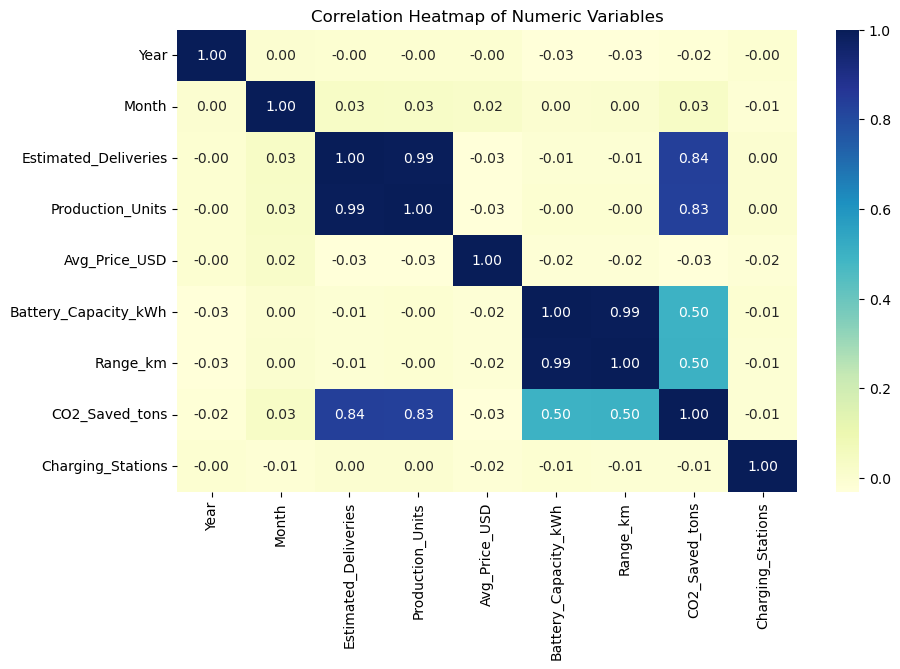

In [5]:
# Numeric-only correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

From the correlation heatmap above, `Estimated_Deliveries` shows a **strong positive correlation** (r = 0.84) with `CO₂_Saved_tons`.  
This suggests that as Tesla delivers more vehicles, total CO₂ savings tend to increase, which makes intuitive sense:  
more electric vehicles on the road replace more gasoline-powered cars, reducing emissions.

To confirm this relationship visually, the next plot displays `CO₂_Saved_tons` against `Estimated_Deliveries`.

3. Scatterplot

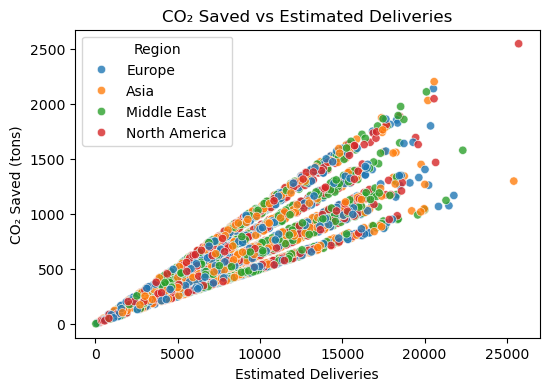

In [7]:
# Create scatterplot
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df,
    x="Estimated_Deliveries",
    y="CO2_Saved_tons",
    hue="Region",
    alpha=0.8
)
plt.title("CO₂ Saved vs Estimated Deliveries")
plt.xlabel("Estimated Deliveries")
plt.ylabel("CO₂ Saved (tons)")
plt.savefig("scatter_CO2_vs_Deliveries.png", dpi=300, bbox_inches="tight")
plt.show()

# Scatterplot interpretation

The scatterplot above shows a clear positive linear relationship between **Estimated Deliveries** and **CO₂ Saved (tons)** across all regions.  
As the number of estimated deliveries increases, the total CO₂ savings also increase, which aligns with expectations — more electric vehicles replacing combustion-engine cars results in greater emission reductions.

The clustering by region (represented by different colors) suggests that the relationship holds consistently across different markets, although the slope may vary slightly by region.  

This visual pattern confirms that a linear regression model is appropriate to test this relationship statistically and quantify how strongly vehicle deliveries predict CO₂ savings.

4. Hypothesis

Based on the observed correlation and scatterplot, the hypothesis for this regression analysis is as follows:

**Research Question:**  
Does an increase in Tesla’s estimated vehicle deliveries lead to higher total CO₂ savings across regions?

**Hypothesis Statement:**  
- **Null Hypothesis (H₀):** There is no linear relationship between *Estimated Deliveries* and *CO₂ Saved (tons)*.  
- **Alternative Hypothesis (H₁):** There is a positive linear relationship between *Estimated Deliveries* and *CO₂ Saved (tons)* — as deliveries increase, CO₂ savings also increase.

This hypothesis will be tested using a **simple linear regression** model, where:
- **Independent variable (X):** Estimated_Deliveries  
- **Dependent variable (y):** CO₂_Saved_tons

If the model reveals a statistically significant positive coefficient for `Estimated_Deliveries`, the null hypothesis will be rejected in favor of the alternative.

5. Data preparation: reshaping variables for regression

In this step, the independent and dependent variables are defined and reshaped into NumPy arrays, which is the format required by the scikit-learn library.

- **Independent variable (X):** `Estimated_Deliveries` — represents Tesla’s estimated vehicle deliveries.  
- **Dependent variable (y):** `CO2_Saved_tons` — represents the amount of CO₂ saved through those deliveries.

In [8]:
# Define independent and dependent variables
X = df["Estimated_Deliveries"].values.reshape(-1, 1)  # independent variable
y = df["CO2_Saved_tons"].values.reshape(-1, 1)        # dependent variable

# Confirm the shape of the arrays
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (2640, 1)
Shape of y: (2640, 1)


# Split the data into training and test sets

In [9]:
# Split data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

6. Regression analysis

In [11]:
# Create a regression object
regression = LinearRegression()

In [12]:
# Fit the regression object on the training set
regression.fit(X_train, y_train)

LinearRegression()

In [13]:
# Predict the values of y using X
y_pred = regression.predict(X_test)

In [14]:
# Display first few predicted vs actual values for comparison
results = pd.DataFrame({
    "Actual_CO2_Saved": y_test.flatten(),
    "Predicted_CO2_Saved": y_pred.flatten()
})
display(results.head())

,Actual_CO2_Saved,Predicted_CO2_Saved
0,439.70,328.495493
1,528.13,383.876718
2,596.50,879.886703
3,893.09,782.515615
4,665.76,569.993948


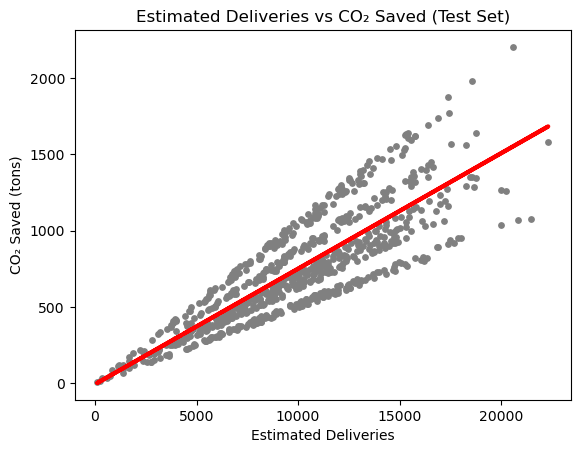

In [16]:
# Create a plot that shows the regression line from the model on the test set
plot_test = plt

plot_test.scatter(X_test, y_test, color='gray', s=15)  # actual data points
plot_test.plot(X_test, y_pred, color='red', linewidth=3)  # regression line

plot_test.title('Estimated Deliveries vs CO₂ Saved (Test Set)')
plot_test.xlabel('Estimated Deliveries')
plot_test.ylabel('CO₂ Saved (tons)')
plot_test.savefig("regression_CO2_vs_deliveries.png", dpi=300, bbox_inches="tight")
plot_test.show()

# Regression line interpretation

The regression plot above shows the relationship between **Estimated Deliveries** and **CO₂ Saved (tons)** for the test set.  

From the visualization, it’s clear that the regression line follows the general upward trend of the data quite well, indicating a **strong positive linear relationship** between estimated deliveries and CO₂ savings.  
As the number of deliveries increases, the amount of CO₂ saved also tends to increase.

However, there is some **dispersion** of points around the line, particularly at higher delivery values.  
This suggests that while the model captures the overall trend effectively, it may not fully account for all variability in the data — possibly due to additional influencing factors (such as regional differences or model type) that are not included in this simple regression.

Overall, the line appears to provide a **good but not perfect fit**, implying that the model is a reasonable predictor of CO₂ savings based on estimated deliveries.

# Model performance evaluation

In [17]:
# Calculate model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [18]:
# Print the model summary statistics
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")

Model Performance Metrics:
Mean Squared Error (MSE): 36562.34
R² Score: 0.6951


# Model performance metrics interpretation
The regression model produced the following results:

- **Mean Squared Error (MSE):** 36,562.34  
- **R² Score:** 0.6951  

An R² value of **0.70 (approximately)** suggests that around **70% of the variance in CO₂ savings** can be explained by the number of estimated deliveries.  
This indicates a **moderately strong linear relationship**, meaning that estimated deliveries are a good — but not perfect — predictor of CO₂ saved.  

The MSE value (36,562.34) shows the average squared deviation between predicted and actual values.  
While not excessively high, it implies that there’s still **some variability not captured** by this simple linear model.  

Overall, the model performs reasonably well:  
- It successfully identifies a clear upward relationship between deliveries and CO₂ saved.  
- However, additional variables (e.g., regional differences, vehicle types, or battery capacity) could help improve predictive accuracy in a multiple regression model.

In [19]:
# Compare actual and predicted CO₂ saved values in a dataframe
comparison_df = pd.DataFrame({
    'Actual_CO2_Saved': y_test.flatten(),
    'Predicted_CO2_Saved': y_pred.flatten()
})

# Display the first few rows for inspection
comparison_df.head(10)

,Actual_CO2_Saved,Predicted_CO2_Saved
0,439.70,328.495493
1,528.13,383.876718
2,596.50,879.886703
3,893.09,782.515615
4,665.76,569.993948
5,831.29,1000.484616
6,1498.45,1138.408076
7,251.46,258.134101
8,567.70,801.581283
9,560.97,822.311414


# Model evaluation

The linear regression model performed moderately well on the test set, as indicated by an **R² score of 0.6951**.  
This means that approximately **70% of the variance in CO₂ saved** can be explained by the number of **Estimated Deliveries**.  
The **Mean Squared Error (MSE) of 36,562.34** suggests that while the model predicts reasonably close to the actual values, there is still some deviation—likely due to other factors not captured in this simple model.

Overall, the regression line fit the data fairly well, confirming the hypothesis that **higher estimated deliveries lead to higher CO₂ savings**.  
However, the dispersion around the line shows that the relationship isn’t perfectly linear, and that other influences (such as regional production efficiency, vehicle types, or charging infrastructure) might affect CO₂ outcomes.

# Reflections on data bias
It’s important to consider that the dataset may contain biases that influence model performance.  
For example:
- If certain regions (like North America or Asia) are overrepresented, the model could learn regional trends that don’t generalize globally.
- Differences in data collection practices, such as estimation methods or reporting accuracy, could distort the relationship.  
- Economic or technological disparities between markets may also bias the observed correlation between deliveries and CO₂ savings.

Recognizing and addressing these potential biases is crucial before using the model for broader prediction or policy recommendations.  
Future analyses could incorporate additional predictors and balance regional representation to improve both accuracy and fairness.